***installing Spacy 2.1.0 and neuralcoref***

> neuralcoref only works with Spacy, 2.1.0. Whilst spacy can be installe dusing Pip or Conda, to install the spacy lg english model and neuralcoref:
- https://v2.spacy.io/models/en
- manually download the model tar https://github.com/explosion/spacy-models/releases//tag/en_core_web_lg-2.3.1#
- install the model locally https://github.com/explosion/spaCy/issues/4577
- install neuralcoref from source
    - https://github.com/huggingface/neuralcoref/issues/197#issuecomment-534028423
    - https://github.com/huggingface/neuralcoref#install-neuralcoref-from-source
    - https://medium.com/huggingface/state-of-the-art-neural-coreference-resolution-for-chatbots-3302365dcf30



In [1]:
import re
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import spacy
import neuralcoref #
from spacy import displacy
try:
    nlp = spacy.load('en_core_web_lg')
except:
    !python -m spacy download en_core_web_lg
    nlp = spacy.load('en_core_web_lg')
from spacy.matcher import Matcher 
from spacy.tokens import Span 

## Load Data

In [2]:
df = pd.read_excel('tesco.xlsx',skiprows=2)
df[:2]

,id,text
0,0,"Tesco has been hit by hackers, leaving thousan..."
1,1,The outage leaves its grocery website and app ...


## Model

- [named entity recognition]()
- [coreference resolution](https://spacy.io/universe/project/neuralcoref)

 
<img src="./model_architecture.svg" width=600 height=400>

In [3]:
example_text = ('Johnny is a big fan of skiing. '
                'He is a man. '
                'Lydia is a woman who likes cycling. '
                'He also enjoys cycling but she is a fan of music. '
                'Tesco Plc is the lagest supermarket chain in the UK. '
                'Their customers shop on average three times per week. '
                'But they buy fuel from other places.'
               )
example_text

'Johnny is a big fan of skiing. He is a man. Lydia is a woman who likes cycling. He also enjoys cycling but she is a fan of music. Tesco Plc is the lagest supermarket chain in the UK. Their customers shop on average three times per week. But they buy fuel from other places.'

## Named Entity Recognition
To extract the named entities

In [4]:
# custom NER
try:
    nlp.remove_pipe('entity_ruler')
#     pass
except:
    config = {
       "phrase_matcher_attr": None,
       "validate": True,
       "overwrite_ents": True,
       "ent_id_sep": "||",
    }
    ruler = nlp.create_pipe("entity_ruler", config=config)
    patterns = [
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(customer)s?' }} ]},
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(shopper)s?' }} ]},
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(hacker)s?' }} ]},
                ]
    ruler.add_patterns(patterns)
    ruler = nlp.add_pipe(ruler)

In [5]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7fdbace32f10>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7fdbace8cd00>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7fdbace8cd70>),
 ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler at 0x7fdba1957350>)]

In [6]:
doc = nlp(example_text)
spacy.displacy.render(doc, style='dep')
print('\n\n')
spacy.displacy.render(doc, style='ent')

In [7]:
# pre-processing
df['text-clean'] = df['text'].apply(lambda x: re.sub(r"(\w+)'s", r'\1s', x))
# apply nlp
df['doc'] = df['text-clean'].apply(lambda x: nlp(x))

df[:2]

,id,text,text-clean,doc
0,0,"Tesco has been hit by hackers, leaving thousan...","Tesco has been hit by hackers, leaving thousan...","(Tesco, has, been, hit, by, hackers, ,, leavin..."
1,1,The outage leaves its grocery website and app ...,The outage leaves its grocery website and app ...,"(The, outage, leaves, its, grocery, website, a..."


### Coreference Resolution

Coreference Resolution is applied to identify and normalise mentions of the same entities within a text. To achieve this, neuralcoref evaluates the position and semantic characteristics of specific terms (e.g. entities, nouns, pronouns) within and across sentences.

In [8]:
try: 
    neuralcoref.add_to_pipe(nlp)
    print(nlp.pipeline)
except:
    print(nlp.pipeline)

[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fdbace32f10>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fdbace8cd00>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7fdbace8cd70>), ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x7fdba1957350>), ('neuralcoref', <neuralcoref.neuralcoref.NeuralCoref object at 0x7fdba18e3cb0>)]


In [9]:
# show initial named entities
doc = """Johnny is a big fan of skiing. He is a man. Lydia is a woman who likes cycling. He also enjoys cycling but she is a fan of music. Tesco Plc is the largest supermarket chain in the UK, their customers shop on average three times per week. But they buy fuel from other places."""
doc = nlp(example_text)
spacy.displacy.render(doc, style='ent')

In [10]:
# show coref results
print(doc._.has_coref)
print("Coref results\t:",doc._.coref_clusters)
print("Coref resolved\t:",doc._.coref_resolved)

# interact with coref result objects
print(type(doc._.coref_scores))

# cluster mentions
k = doc._.coref_clusters
print("Entities found:\t",k)
a = k[0]
print("Entity 1:\t",a)
print("\tMention:\t",a.main.start_char,a.main.end_char)
for i in a.mentions:
    print("\tMentions:\t",i,i.start_char,i.end_char)

True
Coref results	: [Johnny: [Johnny, He, He], Lydia: [Lydia, she], Their customers: [Their customers, they]]
Coref resolved	: Johnny is a big fan of skiing. Johnny is a man. Lydia is a woman who likes cycling. Johnny also enjoys cycling but Lydia is a fan of music. Tesco Plc is the lagest supermarket chain in the UK. Their customers shop on average three times per week. But Their customers buy fuel from other places.
<class 'dict'>
Entities found:	 [Johnny: [Johnny, He, He], Lydia: [Lydia, she], Their customers: [Their customers, they]]
Entity 1:	 Johnny: [Johnny, He, He]
	Mention:	 0 6
	Mentions:	 Johnny 0 6
	Mentions:	 He 31 33
	Mentions:	 He 80 82


In [11]:
# resolved entities
doc = nlp(doc._.coref_resolved)
spacy.displacy.render(doc, style='ent')

## Relation Extraction
To extract realtion ships we must:

### 1. Select the entities
Here there are two important considerations: I) the type of entities to select, ii) reducing those entities to a unique list. 

The type of entities selected determines what relationships and facts you will extract. Options here include: named entities by type; nouns, proper nouns and other word types; and [noun chunks](https://spacy.io/usage/linguistic-features#noun-chunkshttps://spacy.io/usage/linguistic-features#noun-chunks). 


Then, to reduce those named entities and phrases to a unique list, we could apply simple string matching, coreference resolution, or word vector similarity. 

>[***spacy vector example***](https://ashutoshtripathi.com/2020/09/04/word2vec-and-semantic-similarity-using-spacy-nlp-spacy-series-part-7/)
>    ```
>    from scipy.spatial import distance
>    def cosine_similarity(x,y):
>        return 1 - distance.cosine(x,y)
>    queen = nlp.vocab['queen'].vector
>    vqueen = nlp.vocab['king'].vector - nlp.vocab['man'].vector + nlp.vocab['woman'].vector
>    cosine_similarity(queen,vqueen)
>    |0.7880843877792358
>    ```  
>    ```
>
>    # similarity in spacy
>    t1 = nlp('king')
>    t2 = nlp('queen')
>    t1.similarity(t2)
>    ```

To start, lets just use the simple string matching on the Spacy entities that we have extracted following coreference rescoreference. 

In [12]:
## get more types of entity
# def get_entities(doc, verbose=True):
#     entities = dict()
#     for tok in doc:
#         # if tok.pos_ in ['PROPN','NOUN','PRON'] or  tok.ent_type_  != '':
#         if tok.ent_type_ in ['PERSON','ORG','GROUP']:
#             entities[tok.i] = tok # token.i is int location in doc
#             if verbose:
#                 print((tok.text,tok.pos_,tok.dep_,tok.ent_type_,tok.i,tok.idx))
#     return entities
# entities = get_entities(doc)

## get spacy entities using dictionary
# from collections import defaultdict
# def get_spacy_entities(doc):
#     tmp = list()
#     for ent in doc.ents:
#         tmp.append({ent.text.upper():(ent.start_char,ent.end_char)})

#     out = defaultdict(list)
#     for myd in tmp:
#         for k, v in myd.items():
#             out[k].append(v)
#     return dict(out)

## get spacy entities using dataframe
def get_spacy_entities(doc):
    tmp = dict()
    for num,ent in enumerate(doc.ents):
        tmp[num] = dict(mention_id=num,
                        name=ent.text.upper(),
                        type=ent.label_,
                        start=ent.start_char,
                        end=ent.end_char)

    entities = pd.DataFrame.from_dict(data=tmp,orient='index')
    entities['ent_id'] = pd.factorize(entities['name'])[0]
    return entities

entities = get_spacy_entities(doc)
unique_entities = entities[['ent_id','name','type']].drop_duplicates(ignore_index=True)
unique_entities

,ent_id,name,type
0,0,JOHNNY,PERSON
1,1,LYDIA,PERSON
2,2,TESCO PLC,ORG
3,3,UK,GPE
4,4,CUSTOMERS,GROUP
5,5,THREE,CARDINAL


### 2. Evaluate relationships between entities.

- rules based approach ([see this post](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/))
- model based

In [13]:
# RULE BASED METHOD
# # get ordered entity pairs
# def get_entity_pairs(iterable):
#     "s -> (s0,s1), (s1,s2), (s2, s3), ..."
#     a, b = itertools.tee(iterable)
#     next(b, None)
#     return {e:{'from':x[0],'to':x[1]} for e,x in enumerate(zip(a, b))}
# entity_pairs = get_entity_pairs(entities.keys())
# entity_pairs

# # get edge text
# def get_entity_edges(entity_pairs):
#     for k in list(entity_pairs.keys()):
#         v = entity_pairs[k]
#         edge_text = [t.text for t in doc[v['from']:v['to']+1] if t.pos_ in ['VERB','ADP','ADJ']]
#         edge_text = ' '.join(edge_text)
#         if len(edge_text) == 0:
#             del entity_pairs[k]
#         else:
#             v['edge'] = edge_text
    
# get_entity_edges(entity_pairs)
# entity_pairs

we want mention - mention 
but not if same ents

In [14]:
from itertools import permutations
import opennre

In [15]:
look_forward = True
model_nre = opennre.get_model('wiki80_bert_softmax')

if look_forward:
    # symetrical matrix if we include all permutations
    perms = [(i,j) for i,j in permutations(entities['mention_id'], 2)]
    print(len(perms))
else:
    # really, we only want to look forward - and this cuts model runs
    perms = [(i,j) for i,j in permutations(entities['mention_id'], 2) if j>i]
    print(len(perms))
    
relations = list()
for permutation in perms:
    a,b = permutation[0],permutation[1]
    h,t = tuple(entities.iloc[a,[3,4]].values),tuple(entities.iloc[b,[3,4]].values)
    res = permutation+(entities.iloc[a,5],entities.iloc[b,5],entities.iloc[a,1],entities.iloc[b,1])
    res = res + model_nre.infer({'text': doc.text,'h': {'pos': h},'t': {'pos': t}})
    relations.append(res)

relations[:5]

2022-01-15 15:29:03,813 - root - INFO - Loading BERT pre-trained checkpoint.


90


[(0, 1, 0, 0, 'JOHNNY', 'JOHNNY', 'sibling', 0.974736750125885),
 (0, 2, 0, 1, 'JOHNNY', 'LYDIA', 'spouse', 0.7749688029289246),
 (0, 3, 0, 0, 'JOHNNY', 'JOHNNY', 'sibling', 0.9843621253967285),
 (0, 4, 0, 1, 'JOHNNY', 'LYDIA', 'sibling', 0.8408116698265076),
 (0, 5, 0, 2, 'JOHNNY', 'TESCO PLC', 'owned by', 0.9948977828025818)]

In [16]:
# view as a matrix
matrix = np.zeros(shape=(len(entities),len(entities)))
for r in relations: matrix[r[0]][r[1]] = r[7]
df = pd.DataFrame(matrix,columns=entities['name'], index=entities['name'])
df.iloc[:4,:]

name,JOHNNY,JOHNNY,LYDIA,JOHNNY,LYDIA,TESCO PLC,UK,CUSTOMERS,THREE,CUSTOMERS
name,,,,,,,,,,
JOHNNY,0.000000,0.974737,0.774969,0.984362,0.840812,0.994898,0.528288,0.413775,0.310518,0.506160
JOHNNY,0.982016,0.000000,0.766185,0.981474,0.519902,0.989693,0.963262,0.350913,0.541421,0.279308
LYDIA,0.507166,0.499390,0.000000,0.924185,0.430345,0.964352,0.723968,0.313179,0.484531,0.306945
JOHNNY,0.983051,0.976453,0.763529,0.000000,0.943056,0.993842,0.778485,0.257775,0.408379,0.234098


In [17]:
# view as dataframe
df = pd.DataFrame(relations,columns=['source_mention','target_mention','source_id','target_id','name1','name2','relation','score'])
df['type1'] = df['source_id'].map(dict(entities[['ent_id','type']].values))
df['type2'] = df['target_id'].map(dict(entities[['ent_id','type']].values))
df[:4]

,source_mention,target_mention,source_id,target_id,name1,name2,relation,score,type1,type2
0,0,1,0,0,JOHNNY,JOHNNY,sibling,0.974737,PERSON,PERSON
1,0,2,0,1,JOHNNY,LYDIA,spouse,0.774969,PERSON,PERSON
2,0,3,0,0,JOHNNY,JOHNNY,sibling,0.984362,PERSON,PERSON
3,0,4,0,1,JOHNNY,LYDIA,sibling,0.840812,PERSON,PERSON


On interogation of the results, it seems that some relationship types have varying levels of accuracy and relevancy. We can define some simple heuristics to "prune" relationship types that make sense and by accrucay. Naturally, these rules are sensitive to the training data, model tuning, and prediction dataset.

In [18]:
## pruning
df['keep'] = False

# low score, location related
low_relations = ['country of citizenship', 'country of origin', 'headquarters location','part of']
low_threshold=0.5
df.loc[(df['relation'].isin(low_relations)) & (df['score']>=low_threshold) & (df['type2']=='GPE'),'keep']=True

# high score, not same entity
high_threshold = 0.95
df.loc[(df['source_id']!=df['target_id']) & (~df['relation'].isin(low_relations))  & (df['score']>=high_threshold),'keep']=True

# PERSON cannot be owned by ORG
df.loc[(df['type1']=='PERSON') & (df['type2']=='ORG'),'keep']=False

entity_relationships = df.loc[df['keep']==True].reset_index(drop=True)
entity_relationships[:3]

,source_mention,target_mention,source_id,target_id,name1,name2,relation,score,type1,type2,keep
0,0,6,0,3,JOHNNY,UK,country of citizenship,0.528288,PERSON,GPE,True
1,1,6,0,3,JOHNNY,UK,country of origin,0.963262,PERSON,GPE,True
2,2,6,1,3,LYDIA,UK,country of origin,0.723968,PERSON,GPE,True


## Visualise Entity Relationships

In [19]:
# create graph
G=nx.DiGraph(name='simple KG')

# add nodes
for ix,row in unique_entities.iterrows():
    G.add_node(row['ent_id'],name=row['name'], ent_typ=row['type']) 
node_labels = {node[0]:node[1]['name'] for node in G.nodes(data=True)}

# add edges
edges = [(row['source_id'],row['target_id'],{'weight':1, 'relation':row['relation']}) for ix,row in entity_relationships.iterrows()]
edge_labels = {(row['source_id'],row['target_id']):row['relation'] for ix,row in entity_relationships.iterrows()}
G.add_edges_from(edges)

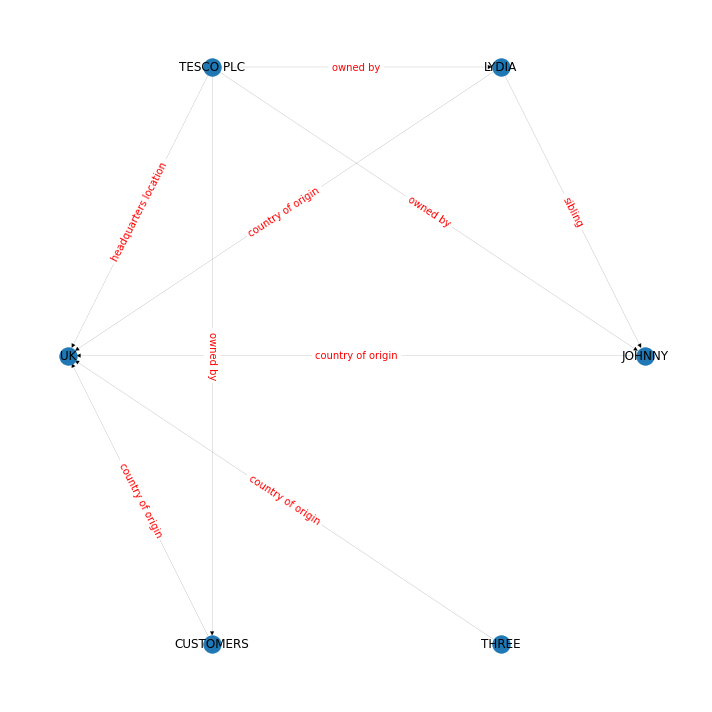

In [20]:
# plot graph
fig,ax = plt.subplots(1,1, figsize=(10,10))
pos = nx.circular_layout(G)

nx.draw(G, 
        ax=ax,
        pos=pos,
        labels=node_labels,
        width=0.1)

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels,
                             font_color='red')
plt.tight_layout()